## Visualizing the Bexar Data

To better understand potential features for future models, I visualized several of the variables. I started by plotting the criminally-linked properties on a map to determine if there was any geographic affiliation. I then visualized the differences between types of ownership. Next, I compared price per square foot across ownership types, foreign ownership, and owners who own multiple properties, among other variables. I then compared YoY price fluctuations between criminally-linked properties and the broader population of data. Lastly, I dropped several variables and plotted correlation.

In [37]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import json

sns.set_style('darkgrid')

import folium
from folium.plugins import HeatMap
from folium import plugins
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy import stats

In [2]:
# Load in data
prop_df = pd.read_hdf('../data/processed/bexar_processed.h5')

### Plot Properties on Map

In [4]:
# Pull out addresses and zip codes for criminally-linked properties
mapping_crim_df = prop_df[prop_df['crim_address'].notna()==True][['crim_address','property_zip']].reset_index()

In [5]:
print(mapping_crim_df.head(10))
print(mapping_crim_df.shape)

   index                                 crim_address property_zip
0  82774  25319 BOERNE STAGE RD SAN ANTONIO, TX 78255        78255
1  87260        24424 BLANCO RD SAN ANTONIO, TX 78260        78260
2  94234      2227 SAWGRASS RDG SAN ANTONIO, TX 78260        78260
3  94265        2243 WINDING VW SAN ANTONIO, TX 78260        78260
4  94696          1115 LINKS CV SAN ANTONIO, TX 78260        78260
5  94703          1220 LINKS LN SAN ANTONIO, TX 78260        78260
6  94705          1228 LINKS LN SAN ANTONIO, TX 78260        78260
7  94760          1247 LINKS LN SAN ANTONIO, TX 78260        78260
8  94761       1103 OLYMPIC CLB SAN ANTONIO, TX 78260        78260
9  95165         1220 PINYON HL SAN ANTONIO, TX 78260        78260
(48, 3)


In [6]:
geolocator = Nominatim(user_agent="property_mapping_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=4)

skip = 1
if skip == 0:
    x = mapping_crim_df['crim_address'].tolist()
    names = []

    for item in x:
        d={}
        a = geocode(item, exactly_one=True, timeout=60)
        try:
            d["Latitude"] = a.latitude
        except:
            pass
        try:
            d["Longitude"] = a.longitude
        except:
            pass
    #     time.sleep(2)
        names.append(d)
        
    mapping_crim_df['coord'] = names

In [7]:
# Now grab the blank coordinates with zip codes
skip = 1

if skip == 0:
    y = mapping_crim_df[mapping_crim_df.coord == {}].property_zip.unique().tolist()
    zip_coords = []

    for item in y:
        d = {}
        a = geocode(item, exactly_one=True, timeout=60)
        try:
            d["Latitude"] = a.latitude
        except:
            pass
        try:
            d["Longitude"] = a.longitude
        except:
            pass
        zip_coords.append(d)
        
    zip_coords_dict = {}
    for i, j in enumerate(y):
        print(zip_coords[i],j)
        zip_coords_dict[j] = zip_coords[i]
        
    # Map onto coord column
    mask = mapping_crim_df[mapping_crim_df.coord=={}].index
    mapping_crim_df.loc[mask,'coord'] = mapping_crim_df.iloc[mask].property_zip.map(zip_coords_dict)

    # Pull out data for mapping
    data = [[row['coord']['Latitude'],row['coord']['Longitude'],row['crim_address']] for index, row in mapping_crim_df.iterrows()]

In [8]:
# Seems some of the coordinates are quite a bit off
# Ignoring those
# mapping_crim_df.head()

In [143]:
skip = 1
if skip == 0:
    # Use folium to map each point
    m = folium.Map(
        location=[29.513151, -98.497901],
        zoom_start=9
    )

    for i in data:
        folium.Marker(
            i[:2],
            popup=i[2],
            icon=folium.Icon(color='red',icon='map-marker',prefix='fa')
        ).add_to(m)

    display(m)
    
    # Save as html
    m.save("crim_prop_map.html")

### Geographic Concentration

The above map seems to indicate that these properties are geographically concentrated; grouping by neighborhood code and zip code may show similar.

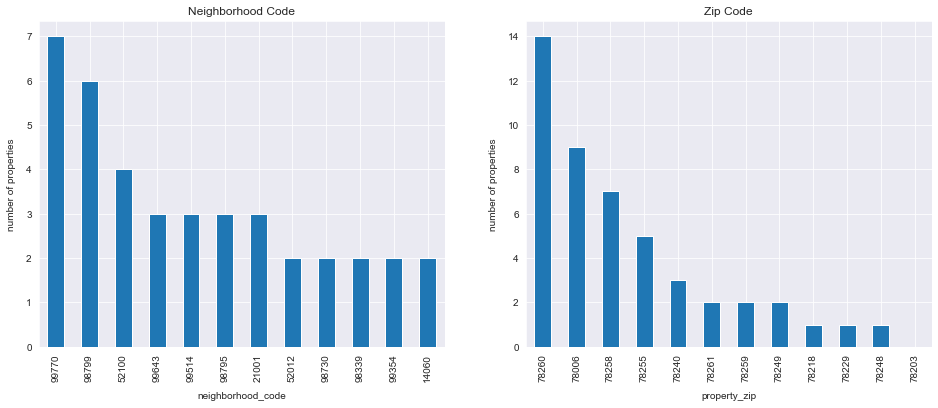

In [9]:
crim_sub_df = prop_df[prop_df.crim_prop==1]
groups = ['neighborhood_code','property_zip']
titles = ['Neighborhood Code','Zip Code']

plots = len(groups)
fig, axes = plt.subplots((int(plots/2)),2,figsize=[16,6])

for ax, var, title in zip(axes.flat,groups,titles):
    crim_sub_df[str(var)].value_counts()[:12].plot(kind='bar',ax=ax,title=title)
    ax.set_xlabel(var,labelpad=10)
    ax.set_ylabel("number of properties",labelpad=10)
plt.show()

These two figures do further indicate there is a geographic component to the properties labeled as criminally-linked.

### Distribution of Last Deed Transfer Date 

How many of the properties in the 2019 dataset have changed hands since 1990?

8448 properties have had their deed transferred since 1990.


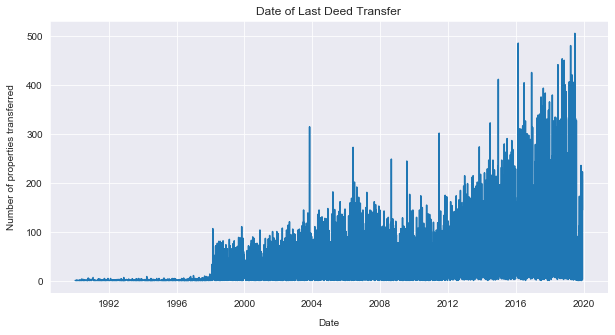

In [10]:
num_transfer = prop_df.deed_dt.value_counts().sort_index().loc['1990-01-01':,].count()
print("{} properties have had their deed transferred since 1990.".format(num_transfer))

# What is the distribution of the deed_dt in the dataset Bexar County
plt.figure(figsize=(10,5))
plt.plot(prop_df.deed_dt.value_counts().sort_index().loc['1990-01-01':,])
plt.title("Date of Last Deed Transfer")
plt.ylabel('Number of properties transferred', labelpad=10)
plt.xlabel('Date', labelpad=10)
plt.show()

### Different Ownership Types Across Labels

In [11]:
# Are these properties owned by companies or people?
print(prop_df[prop_df.crim_prop==1]['owner_legal_person'].value_counts())
print(prop_df[prop_df.crim_prop==1]['owner_likely_company'].value_counts())

1    39
0     9
Name: owner_legal_person, dtype: int64
1    41
0     7
Name: owner_likely_company, dtype: int64


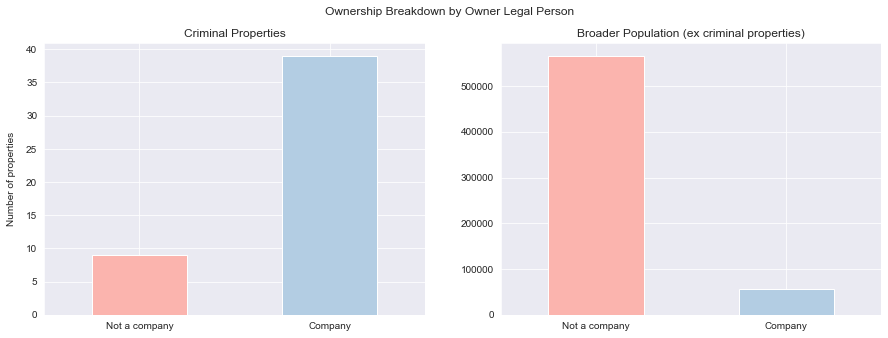

In [12]:
# Plot the breakdown between the two
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Ownership Breakdown by Owner Legal Person")

crim_company_counts = crim_sub_df.owner_legal_person.value_counts().sort_index()
crim_company_counts.index = ['Not a company','Company']
color = plt.cm.Pastel1(np.arange(len(crim_company_counts)))

# Criminially-associated properties
crim_company_counts.plot.bar(
    rot=0,ax=axes[0],
    title="Criminal Properties",
    color=color
)
axes[0].set_ylabel('Number of properties',labelpad=10)

# Broader population (ex criminal properties)
pop_company_counts = prop_df[prop_df.crim_prop!=1].owner_legal_person.value_counts().sort_index()
pop_company_counts.index = ['Not a company','Company']
pop_company_counts.plot.bar(
    rot=0,ax=axes[1],
    title="Broader Population (ex criminal properties)",
    color=color
)

plt.show()

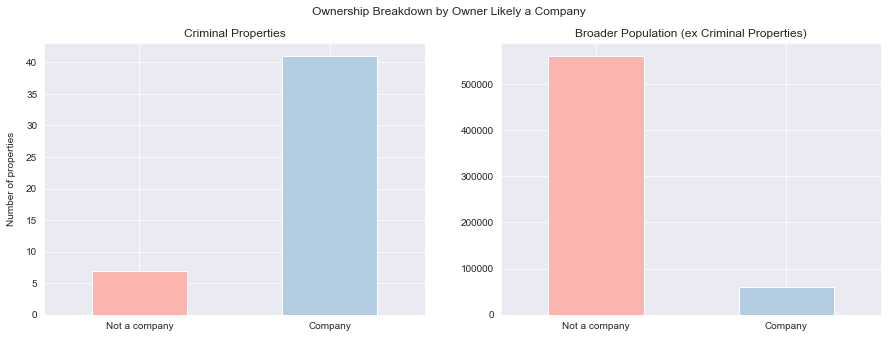

In [13]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Ownership Breakdown by Owner Likely a Company")
crim_likely_co = crim_sub_df.owner_likely_company.value_counts().sort_index()
crim_likely_co.index = ['Not a company','Company']
crim_likely_co.plot.bar(
    rot=0,
    ax=axes[0],
    title="Criminal Properties",
    color=color
    
)
axes[0].set_ylabel('Number of properties',labelpad=10)

pop_likely_co = prop_df[prop_df.crim_prop!=1].owner_likely_company.value_counts().sort_index()
pop_likely_co.index = ['Not a company','Company']
pop_likely_co.plot.bar(
    rot=0,
    ax=axes[1],
    title="Broader Population (ex Criminal Properties)",
    color=color
)
pop_likely_co.index = ['Not a company','Company']
plt.show()

The broader population of residential properties are far more often owned by a natural person than a company. The opposite is true for those properties labeled as criminally-linked, matching a common typology for money-laundering in real property.

### Price PSF Across Different Ownership Types

In [14]:
print("Price psf for properties where the owner is a legal person:")
print(prop_df.groupby('owner_legal_person')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is likely a company:")
print(prop_df.groupby('owner_likely_company')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is a trust:")
print(prop_df.groupby('owner_is_trust')['price_psf'].agg(['describe']))

Price psf for properties where the owner is a legal person:
                    describe                                                \
                       count        mean          std       min        25%   
owner_legal_person                                                           
0                   517598.0  105.582039    80.632885  0.086096  85.000000   
1                    37655.0  167.625694  1119.905659  0.019408  68.120467   

                                                           
                           50%         75%            max  
owner_legal_person                                         
0                   101.126372  118.791452   23736.939394  
1                    94.689737  131.588886  124520.000000   

Price psf for properties where the owner is likely a company:
                      describe                                               \
                         count        mean         std       min        25%   
owner_likely_company       

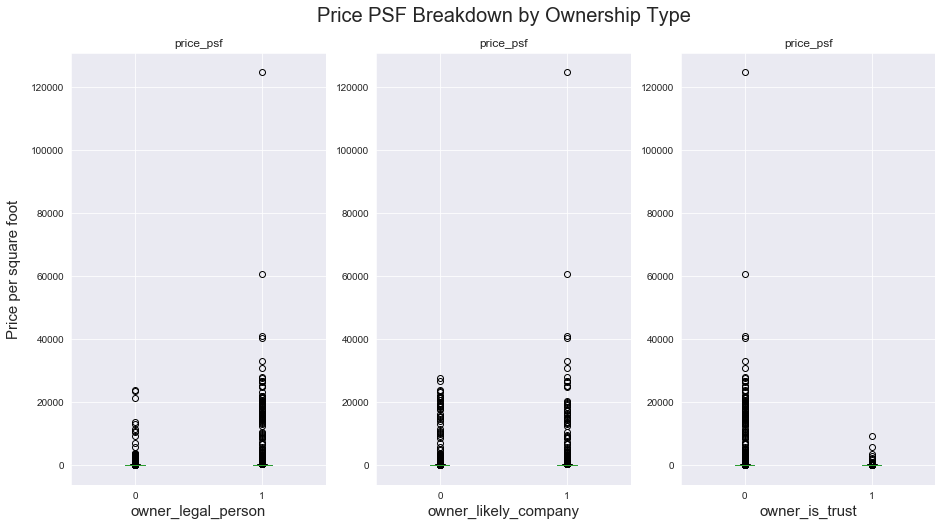

In [15]:
groups = ['owner_legal_person','owner_likely_company','owner_is_trust']
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)
    ax.set_xlabel(var,fontsize=15)
axes[0].set_ylabel('Price per square foot',labelpad=10,fontsize=15)
fig.suptitle("Price PSF Breakdown by Ownership Type",fontsize=20)
plt.show()

In [16]:
# Investigate some of these outlier properties
prop_df[prop_df.price_psf==prop_df.price_psf.max()][[
    'prop_id',
    'prop_type_cd',
    'price_psf',
    'py_owner_name',
    'situs_num',
    'situs_street_prefx',
    'situs_street',
    'situs_city',
    'land_acres',
    'Sq_ft'
]]

,prop_id,prop_type_cd,price_psf,py_owner_name,situs_num,situs_street_prefx,situs_street,situs_city,land_acres,Sq_ft
290945,539799,R,124520.0,CLAYTON GROUP INC,542,NaN,CITRUS RD,SAN ANTONIO,0,1


It seems in this case that for some reason the square footage is listed as 1. The property appears to be an industrial park, so it could be encoded incorrectly as a residential property.

In [20]:
# Inspecting more
prop_df[prop_df.price_psf>=prop_df.price_psf.quantile(.999)][[
    'prop_id',
    'prop_type_cd',
    'price_psf',
    'py_owner_name',
    'situs_num',
    'situs_unit',
    'situs_street_prefx',
    'situs_street',
    'situs_city',
    'land_acres',
    'Sq_ft'
]][:10]

,prop_id,prop_type_cd,price_psf,py_owner_name,situs_num,situs_unit,situs_street_prefx,situs_street,situs_city,land_acres,Sq_ft
362,100970,R,20392.592593,ZARZAMORA MHP LLC,4400,NaN,S,ZARZAMORA,SAN ANTONIO,22500,27
577,101533,R,1542.803030,TOOMEY FAMILY LTD PTSHP,327,NaN,W,MARTIN ST,SAN ANTONIO,3180,528
635,101768,R,1021.740908,DENNYS INC #1516,903,NaN,E,COMMERCE ST,SAN ANTONIO,8730,6847
667,101830,R,1887.389021,LOS LEONES FAMILY LTD PRTSHP,430,NaN,E,COMMERCE ST,SAN ANTONIO,3179,2095
1152,103388,R,698.992443,CANALES TERRY A,811,NaN,NaN,SAN PEDRO AVE,SAN ANTONIO,4574,1588
1155,103392,R,653.887584,ZAGAYER AHARON & HANNA REV TRUST OF 1997,801,NaN,NaN,SAN PEDRO AVE,SAN ANTONIO,4867,1788
1386,103817,R,767.553082,BRAZOS DE SANTOS PARTNERS LTD,501,NaN,N,SAINT MARYS ST,SAN ANTONIO,5427,4851
1424,103935,R,1368.167203,GRAYSTREET TRAVIS GARAGE LLC,213,NaN,E,TRAVIS ST,SAN ANTONIO,12990,10574
1648,104468,R,728.519380,930 BROADWAY LTD,920,NaN,NaN,BROADWAY ST,SAN ANTONIO,3913,1290
1660,104496,R,678.282895,VFW POST 76,10,NaN,NaN,10TH ST,SAN ANTONIO,9600,4560


It may be worth filtering out the top .1% of price_psf:
- 4400 S Zarzamora appears to be the entire lot of a mobile home park.
- 327 W Martin St is a car dealership
- 903 E Commerce St is a Denny's restaurant
- 430 E Commerce St is a restaurant
- 811 San Pedro Ave is a Sonic restaurant
- 801 San Pedro Ave appears to be either a gas station or a Starbucks

In [22]:
# Does this affect the distributions
trim_prop_df = prop_df[prop_df.price_psf<prop_df.price_psf.quantile(.999)]
trim_prop_df.shape

(554697, 78)

In [23]:
print("Price psf for properties where the owner is a legal person:")
print(trim_prop_df.groupby('owner_legal_person')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is likely a company:")
print(trim_prop_df.groupby('owner_likely_company')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is a trust:")
print(trim_prop_df.groupby('owner_is_trust')['price_psf'].agg(['describe']))

Price psf for properties where the owner is a legal person:
                    describe                                              \
                       count        mean        std       min        25%   
owner_legal_person                                                         
0                   517451.0  104.979702  36.159965  0.086096  84.996518   
1                    37246.0  118.346267  88.249259  0.019408  67.789117   

                                                        
                           50%         75%         max  
owner_legal_person                                      
0                   101.117983  118.771374  644.087838  
1                    94.130368  129.445078  644.723389   

Price psf for properties where the owner is likely a company:
                      describe                                              \
                         count        mean        std       min        25%   
owner_likely_company                                  

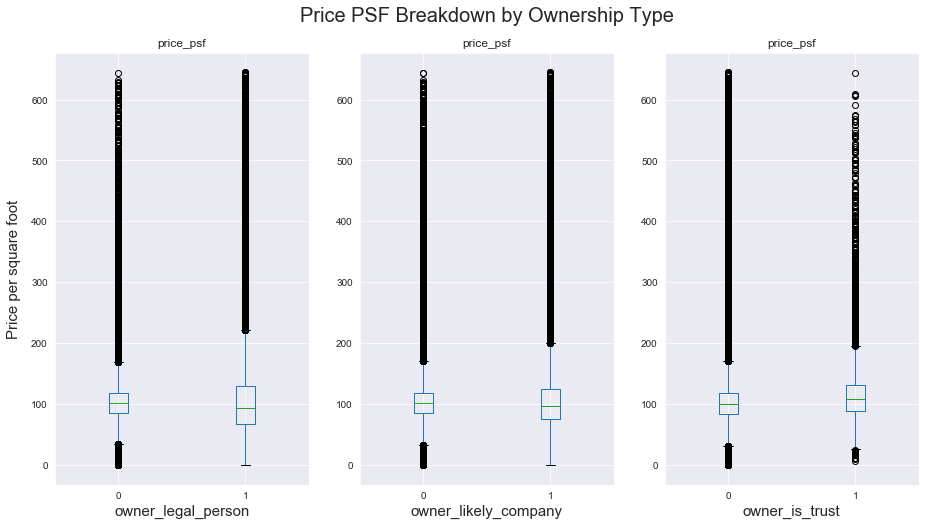

In [26]:
groups = ['owner_legal_person','owner_likely_company','owner_is_trust']
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    trim_prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)
    ax.set_xlabel(var,fontsize=15)
axes[0].set_ylabel('Price per square foot',labelpad=10,fontsize=15)
fig.suptitle("Price PSF Breakdown by Ownership Type",fontsize=20)
plt.show()

For cases where the owner is coded as either a legal person, "likely a company," or trust, the mean price per square foot is higher. However, the median price per square foot for the first two is lower than the median price where the owner is not a legal person or likely a company. This makes sense given the outliers visible in the boxplots.

In [27]:
print("Price psf for properties where the two measurable GTO requirements are met:")
print(trim_prop_df.groupby('two_gto_reqs')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is foreign-based:")
print(trim_prop_df.groupby('foreign_based_owner')['price_psf'].agg(['describe']),'\n')

Price psf for properties where the two measurable GTO requirements are met:
              describe                                               \
                 count        mean         std       min        25%   
two_gto_reqs                                                          
0             537020.0  104.289317   36.438139  0.019408  84.317290   
1              17677.0  154.117108  110.888050  1.815750  76.154806   

                                                  
                     50%         75%         max  
two_gto_reqs                                      
0             100.614564  118.316940  644.087838  
1             120.622042  195.685016  644.723389   

Price psf for properties where the owner is foreign-based:
                     describe                                               \
                        count        mean        std        min        25%   
foreign_based_owner                                                          
0                 

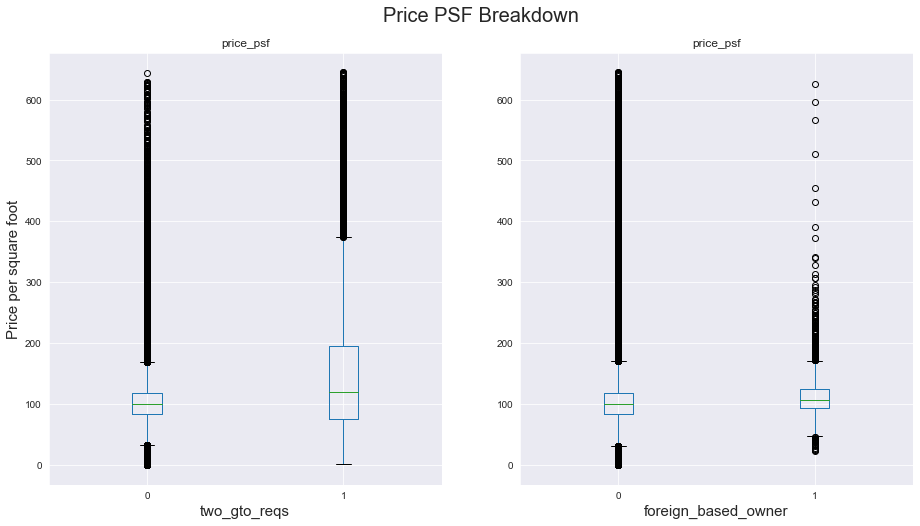

In [28]:
groups = ['two_gto_reqs','foreign_based_owner']
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    trim_prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)
    ax.set_xlabel(var,fontsize=15)

axes[0].set_ylabel('Price per square foot',fontsize=15)
fig.suptitle("Price PSF Breakdown",fontsize=20)
plt.show()

A t-test will determine if the difference in mean price psf for the above binary variables is statistically significant.

In [35]:
print('Mean price psf for properties that meet the two GTO requirements:')
print(trim_prop_df[trim_prop_df.two_gto_reqs==1].price_psf.mean(),'\n')
print('Mean price psf for properties that do not meet the two GTO requirements:')
print(trim_prop_df[trim_prop_df.two_gto_reqs==0].price_psf.mean(),'\n')

Mean price psf for properties that meet the two GTO requirements:
154.11710761885925 

Mean price psf for properties that do not meet the two GTO requirements:
104.2893167510059


In [43]:
stats.ttest_ind(trim_prop_df[trim_prop_df.two_gto_reqs==0].price_psf,
                trim_prop_df[trim_prop_df.two_gto_reqs==1].price_psf)

Ttest_indResult(statistic=-159.1633646536922, pvalue=0.0)

Given the p-value is returned as 0.0, it does appear the difference in mean price psf for properties that meet the price and ownership type components of FinCEN's GTO and those that do not is statistically significant.

In [41]:
print('Mean price psf for properties that meet the two GTO requirements:')
print(trim_prop_df[trim_prop_df.foreign_based_owner==1].price_psf.mean(),'\n')
print('Mean price psf for properties that do not meet the two GTO requirements:')
print(trim_prop_df[trim_prop_df.foreign_based_owner==0].price_psf.mean(),'\n')

Mean price psf for properties that meet the two GTO requirements:
113.2115118426925 

Mean price psf for properties that do not meet the two GTO requirements:
105.83344741901512 



In [44]:
stats.ttest_ind(trim_prop_df[trim_prop_df.foreign_based_owner==0].price_psf,
                trim_prop_df[trim_prop_df.foreign_based_owner==1].price_psf)

Ttest_indResult(statistic=-10.07758577711993, pvalue=6.974031071800331e-24)

The p-value when comparing mean price psf for properties with a foreign-based owner and not would also indicate that the difference in the mean values is statistically significant.

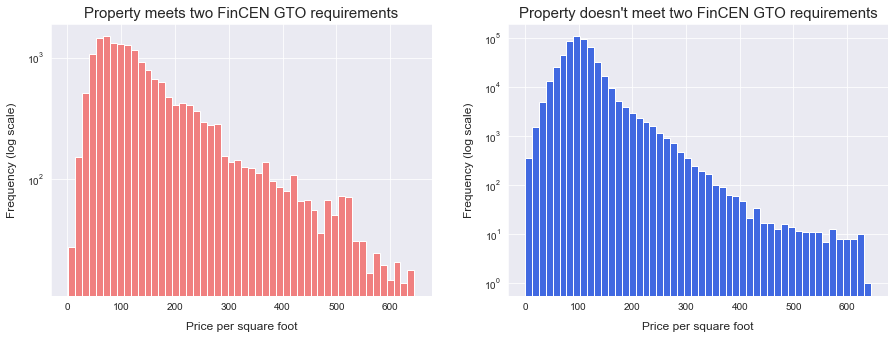

In [45]:
fig, axes = plt.subplots(1,2,figsize=[15,5])

trim_prop_df[trim_prop_df['two_gto_reqs']==1].price_psf.dropna().plot(
    kind='hist',
    ax=axes[0],
    bins=50,
    log=True,
    color='lightcoral'
)

trim_prop_df[trim_prop_df['two_gto_reqs']!=1].price_psf.dropna().plot(
    kind='hist',
    ax=axes[1],
    bins=50,
    log=True,
    color='royalblue'
)

axes[0].set_ylabel('Frequency (log scale)',labelpad=10,fontsize=12)
axes[1].set_ylabel('Frequency (log scale)',labelpad=10,fontsize=12)

axes[0].set_xlabel('Price per square foot',labelpad=10,fontsize=12)
axes[1].set_xlabel('Price per square foot',labelpad=10,fontsize=12)

axes[0].set_title('Property meets two FinCEN GTO requirements',fontsize=15)
axes[1].set_title('Property doesn\'t meet two FinCEN GTO requirements',fontsize=15)

plt.show()

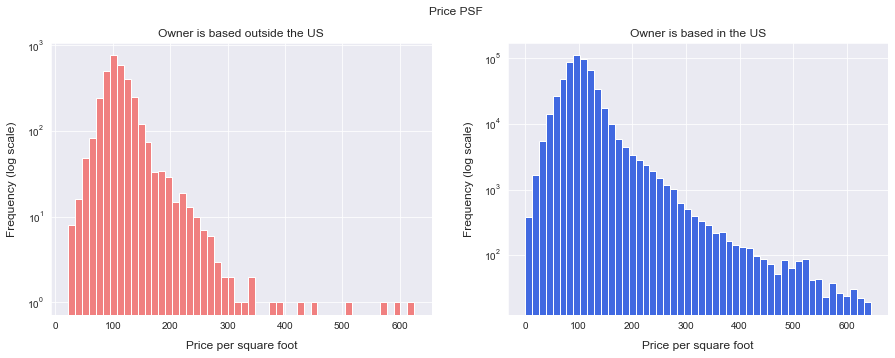

In [59]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Price PSF")
trim_prop_df[trim_prop_df['foreign_based_owner']==1].price_psf.dropna().plot(
    kind='hist',
    ax=axes[0],
    bins=50,
    log=True,
    color='lightcoral'
)

trim_prop_df[trim_prop_df['foreign_based_owner']!=1].price_psf.dropna().plot(
    kind='hist',
    ax=axes[1],
    bins=50,
    log=True,
    color='royalblue'
)

axes[0].set_ylabel('Frequency (log scale)',labelpad=10,fontsize=12)
axes[1].set_ylabel('Frequency (log scale)',labelpad=10,fontsize=12)

axes[0].set_xlabel('Price per square foot',labelpad=10,fontsize=12)
axes[1].set_xlabel('Price per square foot',labelpad=10,fontsize=12)

axes[0].set_title('Owner is based outside the US',fontsize=12)
axes[1].set_title('Owner is based in the US',fontsize=12)


plt.show()

### Just-Established Owner and Owner Owns Multiple Properties
Does a just-established owner pay a higher price psf? What about an owner that owns multiple properties?

In [47]:
print("Price psf for properties where the owner is just-established:")
print(trim_prop_df.groupby('just_established_owner')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner owns multiple properties:")
print(trim_prop_df.groupby('owner_owns_multiple')['price_psf'].agg(['describe']),'\n')

Price psf for properties where the owner is just-established:
                        describe                                              \
                           count        mean        std       min        25%   
just_established_owner                                                         
0                       543751.0  105.573697  40.631750  0.019408  84.318068   
1                        10946.0  120.955046  81.455858  0.031926  77.372374   

                                                            
                               50%         75%         max  
just_established_owner                                      
0                       100.861742  118.985055  644.722689  
1                        98.643151  129.715894  644.723389   

Price psf for properties where the owner owns multiple properties:
                     describe                                              \
                        count        mean        std       min        25%   
owner_own

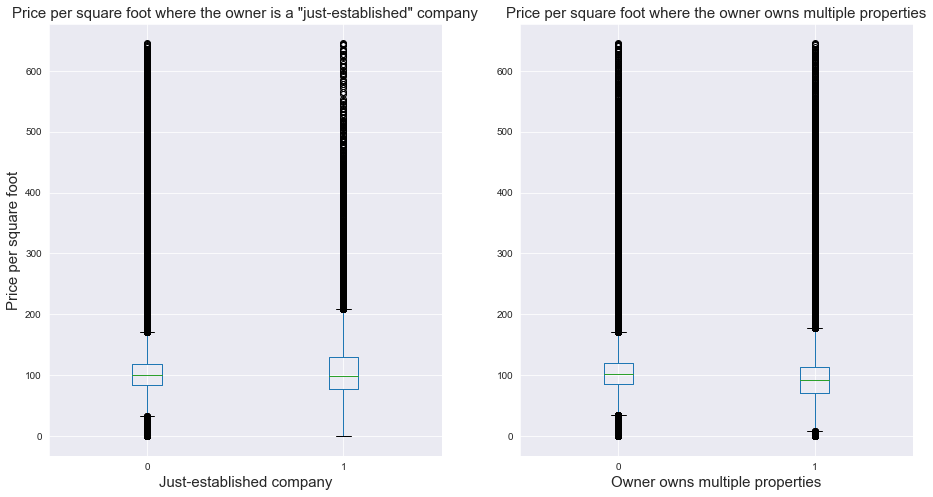

In [48]:
groups = ['just_established_owner','owner_owns_multiple']
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    trim_prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)
    
axes[0].set_ylabel('Price per square foot',fontsize=15)

axes[0].set_xlabel('Just-established company',fontsize=15)
axes[1].set_xlabel('Owner owns multiple properties',fontsize=15)

axes[0].set_title('Price per square foot where the owner is a "just-established" company',fontsize=15)
axes[1].set_title('Price per square foot where the owner owns multiple properties',fontsize=15)

plt.suptitle('')
plt.show()

While there are some outliers making the average higher, the median price per square foot for properties owned by companies established in the last 365 days is actually lower. It is a similar case for when the property owner owns multiple properties.

### Visualizing YoY Price Fluctuations

How do the fluctuations in price year-over-year differ between positively-labeled properties and the broader population?

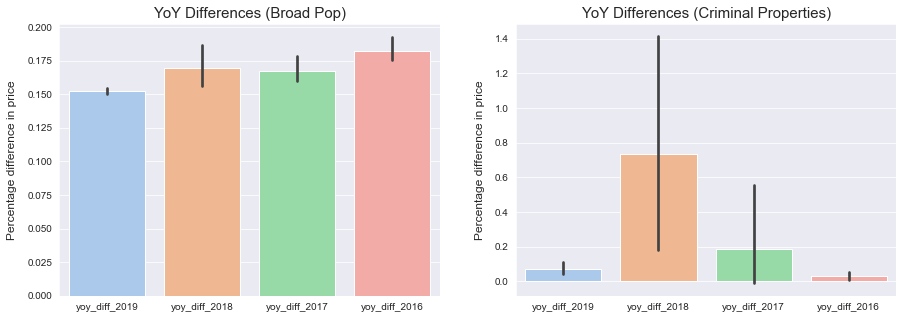

In [49]:
prop_melt = pd.melt(trim_prop_df[trim_prop_df.crim_prop!=1][['yoy_diff_2019','yoy_diff_2018','yoy_diff_2017','yoy_diff_2016']],var_name='year',value_name='yoy_diff').dropna()
crim_sub_melt = pd.melt(trim_prop_df[trim_prop_df.crim_prop==1][['yoy_diff_2019','yoy_diff_2018','yoy_diff_2017','yoy_diff_2016']],var_name='year',value_name='yoy_diff').dropna()

fig, axes = plt.subplots(1,2,figsize=[15,5])
sns.barplot(
    x='year',
    y='yoy_diff',
    data=prop_melt,
    palette='pastel',
    ax=axes[0]).set_title('YoY Differences (Broad Pop)',fontsize=15)
sns.barplot(
    x='year',
    y='yoy_diff',
    data=crim_sub_melt,
    palette='pastel',
    ax=axes[1]).set_title('YoY Differences (Criminal Properties)',fontsize=15)

axes[0].set_ylabel('Percentage difference in price',labelpad=10,fontsize=12)
axes[1].set_ylabel('Percentage difference in price',labelpad=10,fontsize=12)

axes[0].set_xlabel('')
axes[1].set_xlabel('')

plt.show()

### Missing Values

Identifying how many missing values there are per variable will allow meto to narrow down the list of variables that will be used in modeling.

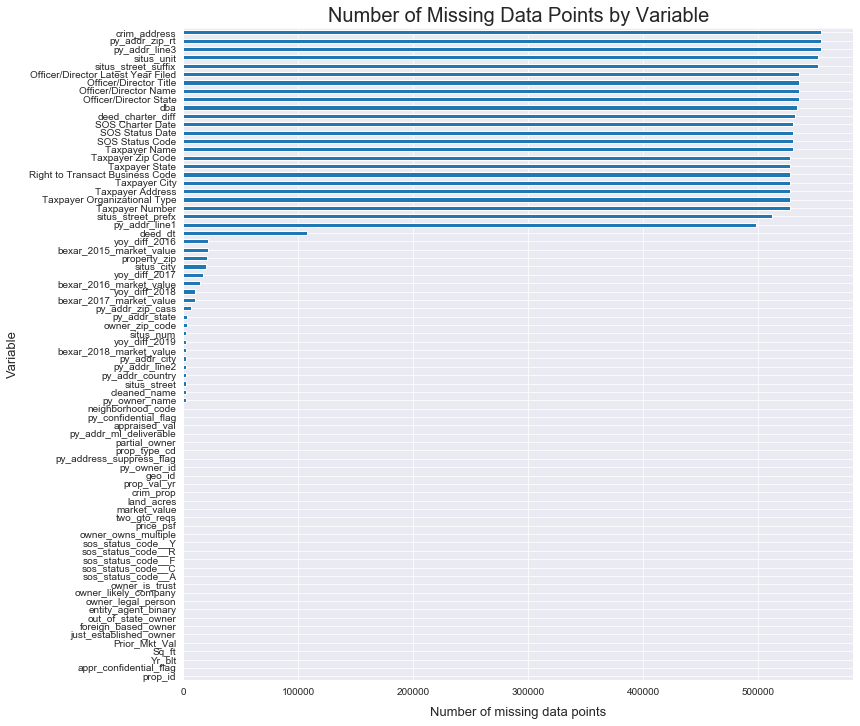

In [51]:
# How many missing values
ax = trim_prop_df.isnull().sum().sort_values().plot.barh(figsize = [12,12])
ax.set_title('Number of Missing Data Points by Variable',fontsize=20)
ax.set_xlabel('Number of missing data points',labelpad=10,fontsize=13)
ax.set_ylabel('Variable',labelpad=10,fontsize=13)
plt.show()

This is generally in line with what I was expecting. Most of the missing variables are from the companies data merge. Aside from owner_zip_code, the others will be dropped as features.

In [61]:
print('YoY Diff 2016 nulls:')
print(trim_prop_df.yoy_diff_2016.isnull().sum(),'\n')

YoY Diff 2016 nulls:
21555 



### Correlation Matrix

In [53]:
# Setting the number of acceptable NaN values to 70,000 to be sure to include Price PSF as a feature
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop(['prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
                                     'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
                                      'bexar_2017_market_value','bexar_2018_market_value'])

print(variables_list)

Index(['partial_owner', 'py_confidential_flag', 'py_address_suppress_flag',
       'py_addr_ml_deliverable', 'land_acres', 'market_value',
       'appr_confidential_flag', 'Yr_blt', 'Sq_ft', 'just_established_owner',
       'foreign_based_owner', 'yoy_diff_2019', 'yoy_diff_2018',
       'yoy_diff_2017', 'yoy_diff_2016', 'out_of_state_owner',
       'entity_agent_binary', 'owner_legal_person', 'owner_likely_company',
       'owner_is_trust', 'sos_status_code__A', 'sos_status_code__C',
       'sos_status_code__F', 'sos_status_code__R', 'sos_status_code__Y',
       'owner_owns_multiple', 'price_psf', 'two_gto_reqs', 'property_zip',
       'neighborhood_code', 'owner_zip_code', 'crim_prop'],
      dtype='object')


In [54]:
trim_prop_df[variables_list].head(10)

,partial_owner,py_confidential_flag,py_address_suppress_flag,py_addr_ml_deliverable,land_acres,market_value,appr_confidential_flag,Yr_blt,Sq_ft,just_established_owner,...,sos_status_code__F,sos_status_code__R,sos_status_code__Y,owner_owns_multiple,price_psf,two_gto_reqs,property_zip,neighborhood_code,owner_zip_code,crim_prop
0,0,0,0,1,11870,587780,0,1984,3243,0,...,0,0,0,1,181.245760,1,78212,10330,78212.0,0.0
1,0,0,0,1,2640,300000,0,1915,2722,0,...,0,0,0,0,110.213079,0,78212,57027,78212.0,0.0
2,0,0,0,1,2041,165000,0,1951,994,0,...,0,0,0,1,165.995976,0,78212,57027,77406.0,0.0
3,0,0,0,1,1388,154630,0,2004,1968,0,...,0,0,0,1,78.572154,0,78212,57027,77406.0,0.0
6,0,0,0,1,3649,336580,0,1923,4600,0,...,0,0,0,0,73.169565,1,78212,10480,78212.0,0.0
7,0,0,0,0,5152,488410,0,1923,11500,0,...,0,0,0,0,42.470435,1,78212,10480,78213.0,0.0
8,0,0,0,1,3000,205000,0,1910,842,0,...,0,0,0,1,243.467933,0,78212,57032,78212.0,0.0
9,0,0,0,1,6001,444300,0,1959,2973,0,...,0,0,0,0,149.445005,0,78212,57032,78212.0,0.0
10,0,0,0,1,3587,310000,0,1925,1113,0,...,0,0,0,0,278.526505,0,78212,57032,78209.0,0.0
11,0,0,0,1,2424,463130,0,2015,1443,0,...,0,0,0,0,320.949411,0,78212,57032,78212.0,0.0


In [55]:
# Pull out variables and plot correlation matrix
sub_df = trim_prop_df[variables_list]
print(len(variables_list))
sub_df.corr()

32


,partial_owner,py_confidential_flag,py_address_suppress_flag,py_addr_ml_deliverable,land_acres,market_value,appr_confidential_flag,Yr_blt,Sq_ft,just_established_owner,...,owner_is_trust,sos_status_code__A,sos_status_code__C,sos_status_code__F,sos_status_code__R,sos_status_code__Y,owner_owns_multiple,price_psf,two_gto_reqs,crim_prop
partial_owner,1.000000,-0.003089,-0.003886,0.024310,-0.001026,-0.017940,-0.003077,-0.018714,-0.007368,-0.008715,...,-0.005552,-0.012309,-0.000165,-0.000655,-0.004005,-0.000117,-0.020502,-0.085796,-0.011144,-0.000481
py_confidential_flag,-0.003089,1.000000,0.799633,0.026923,-0.000030,-0.000499,0.991615,0.014336,-0.002378,-0.009235,...,-0.008727,-0.013203,-0.000175,-0.000694,-0.004244,-0.000124,0.176953,0.012250,-0.011017,-0.000510
py_address_suppress_flag,-0.003886,0.799633,1.000000,0.033559,0.000730,0.004040,0.792887,0.011353,-0.001796,-0.008775,...,-0.002725,-0.012206,-0.000218,-0.000865,-0.003566,-0.000154,0.151759,0.021118,-0.011024,-0.000635
py_addr_ml_deliverable,0.024310,0.026923,0.033559,1.000000,-0.007182,0.036868,0.026780,0.104994,0.021512,0.050076,...,0.042821,0.060209,0.001117,0.002526,0.019218,0.000790,0.024366,0.058740,0.019515,0.003257
land_acres,-0.001026,-0.000030,0.000730,-0.007182,1.000000,0.181588,-0.000019,-0.006103,0.146406,0.035074,...,0.005174,0.042603,0.000147,0.002804,0.011838,0.001367,0.044277,0.126248,0.113857,0.000915
market_value,-0.017940,-0.000499,0.004040,0.036868,0.181588,1.000000,-0.000525,0.060845,0.832052,0.218244,...,0.014444,0.228098,0.018403,0.031669,0.036648,0.017456,0.070525,0.219172,0.499249,0.010395
appr_confidential_flag,-0.003077,0.991615,0.792887,0.026780,-0.000019,-0.000525,1.000000,0.014259,-0.002392,-0.009213,...,-0.008495,-0.013029,-0.000174,-0.000692,-0.004234,-0.000123,0.175760,0.012125,-0.010829,-0.000508
Yr_blt,-0.018714,0.014336,0.011353,0.104994,-0.006103,0.060845,0.014259,1.000000,0.034094,0.005986,...,0.001511,0.001471,0.000833,0.003744,-0.015928,0.000351,-0.061399,0.077083,0.005374,0.005098
Sq_ft,-0.007368,-0.002378,-0.001796,0.021512,0.146406,0.832052,-0.002392,0.034094,1.000000,0.182461,...,0.005510,0.190912,0.008572,0.020088,0.038847,0.010065,0.069982,-0.014539,0.428649,0.006242
just_established_owner,-0.008715,-0.009235,-0.008775,0.050076,0.035074,0.218244,-0.009213,0.005986,0.182461,1.000000,...,-0.018533,0.656609,0.014100,0.044709,0.110940,0.006557,0.224944,0.051082,0.334010,0.015446


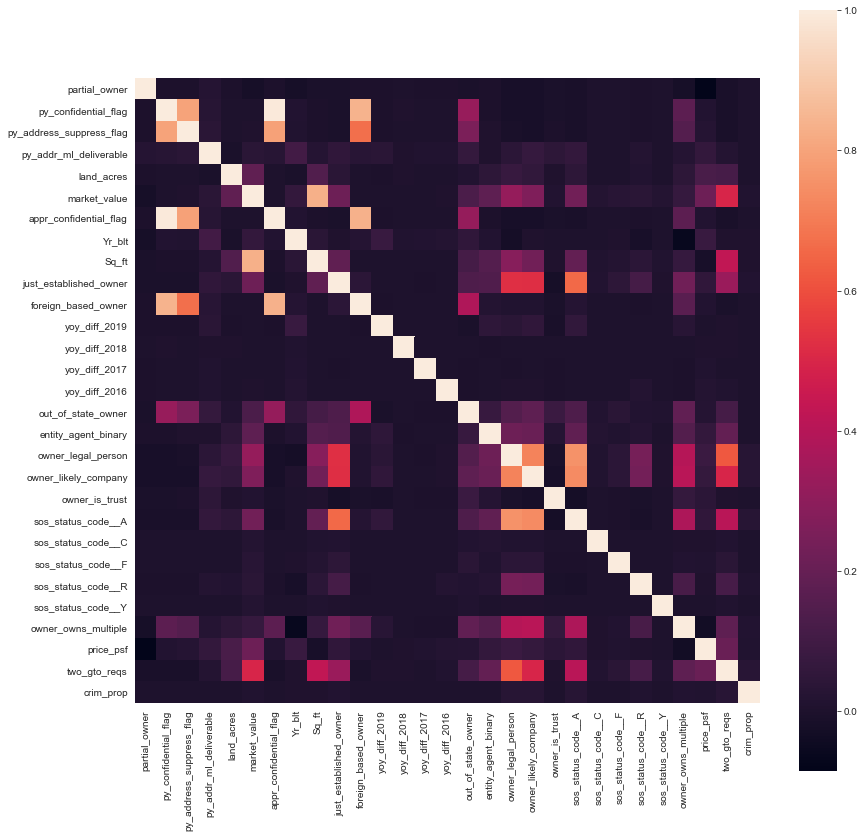

In [57]:
plt.figure(figsize=(14,14))
sns.heatmap(sub_df.corr(),vmax=1,square=True)
plt.show()

Observations:
- High correlation amongst the "confidential flag" variables, which makes sense. 
- High correlation between market value and square footage, which is expected.
- Does not seem to be much correlation between the criminal property label and the other variables